<font size="8">Trace Analysis Examples</font>
<br>
<font size="5">Kernel Functions Profiling</font>
<br>
<hr>

# Import Required Modules

In [1]:
import logging
from conf import LisaLogging
LisaLogging.setup()

In [2]:
# Generate plots inline
%matplotlib inline

import json
import os

# Support to access the remote target
import devlib
from env import TestEnv

# RTApp configurator for generation of PERIODIC tasks
from wlgen import RTA, Ramp

# Support for trace events analysis
from trace import Trace

Populating the interactive namespace from numpy and matplotlib


# Target Configuration

In [3]:
# Setup target configuration
my_conf = {

    # Target platform and board
    "platform"    : 'linux',
    "board"       : 'juno',
    "host"        : '192.168.0.1',

    # Folder where all the results will be collected
    "results_dir" : "TraceAnalysis_FunctionsProfiling",

    # Define devlib modules to load
    "exclude_modules" : [ 'hwmon' ],

    # FTrace events to collect for all the tests configuration which have
    # the "ftrace" flag enabled
    "ftrace"  : {
        "functions" : [
            "pick_next_task_fair",
            "select_task_rq_fair",
            "enqueue_task_fair",
            "update_curr_fair",
            "dequeue_task_fair",
        ],
        
         "buffsize" : 100 * 1024,
    },

    # Tools required by the experiments
    "tools"   : [ 'trace-cmd', 'rt-app' ],
    
    # Comment this line to calibrate RTApp in your own platform
    "rtapp-calib" :  {"0": 360, "1": 142, "2": 138, "3": 352, "4": 352, "5": 353},
}

In [4]:
# Initialize a test environment using:
te = TestEnv(my_conf, wipe=False, force_new=True)
target = te.target

03:35:25  INFO    :         Target - Using base path: /home/derkling/Code/lisa
03:35:25  INFO    :         Target - Loading custom (inline) target configuration
03:35:25  INFO    :         Target - Devlib modules to load: ['bl', 'cpufreq']
03:35:25  INFO    :         Target - Connecting linux target:
03:35:25  INFO    :         Target -   username : root
03:35:25  INFO    :         Target -       host : 192.168.0.1
03:35:25  INFO    :         Target -   password : 
03:35:25  INFO    :         Target - Connection settings:
03:35:25  INFO    :         Target -    {'username': 'root', 'host': '192.168.0.1', 'password': ''}
03:35:29  INFO    :         Target - Initializing target workdir:
03:35:29  INFO    :         Target -    /root/devlib-target
03:35:34  INFO    :         Target - Topology:
03:35:34  INFO    :         Target -    [[0, 3, 4, 5], [1, 2]]
03:35:35  INFO    :       Platform - Loading default EM:
03:35:35  INFO    :       Platform -    /home/derkling/Code/lisa/libs/utils/pla

# Workload Execution and Functions Profiling Data Collection

In [5]:
def experiment(te):

    # Create and RTApp RAMP task
    rtapp = RTA(te.target, 'ramp', calibration=te.calibration())
    rtapp.conf(kind='profile',
               params={
                    'ramp' : Ramp(
                        start_pct =  60,
                        end_pct   =  20,
                        delta_pct =   5,
                        time_s    =   0.5).get()
              })

    # FTrace the execution of this workload
    te.ftrace.start()
    rtapp.run(out_dir=te.res_dir)
    te.ftrace.stop()

    # Collect and keep track of the trace
    trace_file = os.path.join(te.res_dir, 'trace.dat')
    te.ftrace.get_trace(trace_file)
    
    # Collect and keep track of the Kernel Functions performance data
    stats_file = os.path.join(te.res_dir, 'trace.stats')
    te.ftrace.get_stats(stats_file)

    # Dump platform descriptor
    te.platform_dump(te.res_dir)

In [6]:
experiment(te)

03:35:38  INFO    :          WlGen - Setup new workload ramp
03:35:38  INFO    :          RTApp - Workload duration defined by longest task
03:35:38  INFO    :          RTApp - Default policy: SCHED_OTHER
03:35:38  INFO    :          RTApp - ------------------------
03:35:38  INFO    :          RTApp - task [ramp], sched: using default policy
03:35:38  INFO    :          RTApp -  | calibration CPU: 1
03:35:38  INFO    :          RTApp -  | loops count: 1
03:35:38  INFO    :          RTApp - + phase_000001: duration 0.500000 [s] (5 loops)
03:35:38  INFO    :          RTApp - |  period   100000 [us], duty_cycle  60 %
03:35:38  INFO    :          RTApp - |  run_time  60000 [us], sleep_time  40000 [us]
03:35:38  INFO    :          RTApp - + phase_000002: duration 0.500000 [s] (5 loops)
03:35:38  INFO    :          RTApp - |  period   100000 [us], duty_cycle  55 %
03:35:38  INFO    :          RTApp - |  run_time  55000 [us], sleep_time  45000 [us]
03:35:38  INFO    :          RTApp - + phas

# Parse Trace and Profiling Data

In [7]:
# Base folder where tests folder are located
res_dir = te.res_dir
logging.info('Content of the output folder %s', res_dir)
!tree {res_dir}

03:35:53  INFO    : Content of the output folder /home/derkling/Code/lisa/results/TraceAnalysis_FunctionsProfiling


/home/derkling/Code/lisa/results/TraceAnalysis_FunctionsProfiling
├── output.log
├── platform.json
├── ramp_00.json
├── rt-app-ramp-0.log
├── trace.dat
├── trace.raw.txt
├── trace.stats
└── trace.txt

0 directories, 8 files


In [8]:
with open(os.path.join(res_dir, 'platform.json'), 'r') as fh:
    platform = json.load(fh)
#print json.dumps(platform, indent=4)
logging.info('LITTLE cluster max capacity: %d',
             platform['nrg_model']['little']['cpu']['cap_max'])

03:35:53  INFO    : LITTLE cluster max capacity: 447


In [9]:
trace = Trace(platform, res_dir, events=[])

03:21:10  INFO    : Parsing FTrace format...
03:21:10  INFO    : Trace contains only functions stats
03:21:10  INFO    : Collected events spans a 0.000 [s] time interval
03:21:10  INFO    : Set plots time range to (0.000000, 0.000000)[s]
03:21:10  INFO    : Registering trace analysis modules:
03:21:10  INFO    :    frequency
03:21:10  INFO    :    functions
03:21:10  INFO    :    tasks
03:21:10  INFO    :    eas
03:21:10  INFO    :    status
03:21:10  INFO    :    cpus


# Report Functions Profiling Data

In [10]:
# Get the DataFrame for the specified list of kernel functions
df = trace.data_frame.functions_stats(['enqueue_task_fair', 'dequeue_task_fair'])
df

hits    avg     time    s_2
0 dequeue_task_fair   538  3.372  1814.54  5.544
  enqueue_task_fair   571  3.214  1835.56  2.027
1 dequeue_task_fair    12  3.501    42.02  1.593
  enqueue_task_fair    17  3.076    52.30  0.593
2 dequeue_task_fair  1160  2.469  2864.78  2.218
  enqueue_task_fair  1164  2.177  2535.18  0.999
3 dequeue_task_fair   304  2.362   718.34  3.015
  enqueue_task_fair   279  2.538   708.18  1.082
4 dequeue_task_fair   199  2.646   526.58  2.827
  enqueue_task_fair   215  2.571   552.78  0.903
5 dequeue_task_fair    88  2.407   211.82  2.773
  enqueue_task_fair    59  2.774   163.70  1.491

In [10]:
# Get the DataFrame for the single specified kernel function
df = trace.data_frame.functions_stats('select_task_rq_fair')
df

,,hits,avg,time,s_2
0,select_task_rq_fair,783,1.617,1266.88,0.896
1,select_task_rq_fair,17,0.782,13.30,0.031
2,select_task_rq_fair,777,1.042,810.16,3.248
3,select_task_rq_fair,259,1.575,408.12,8.924
4,select_task_rq_fair,186,1.837,341.72,4.420
5,select_task_rq_fair,51,2.557,130.42,13.227


# Plot Functions Profiling Data

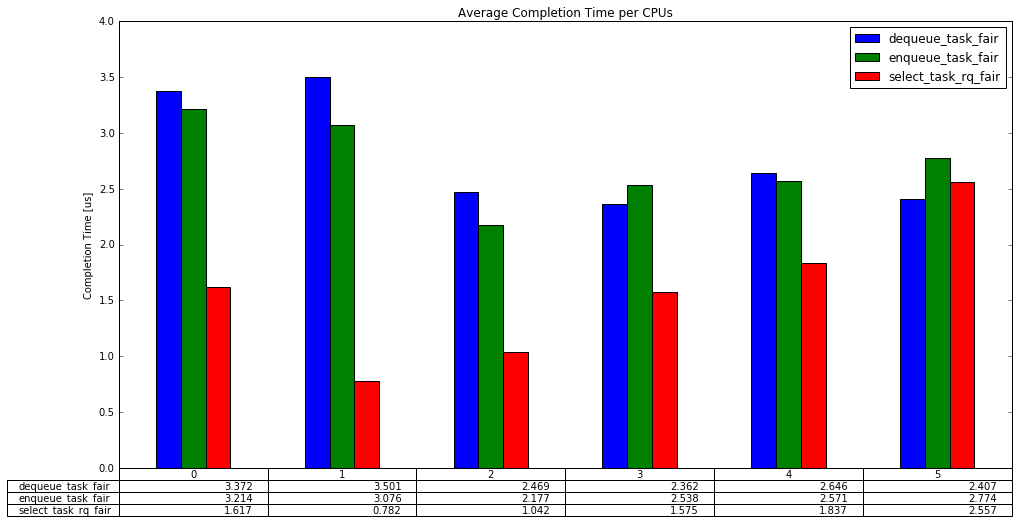

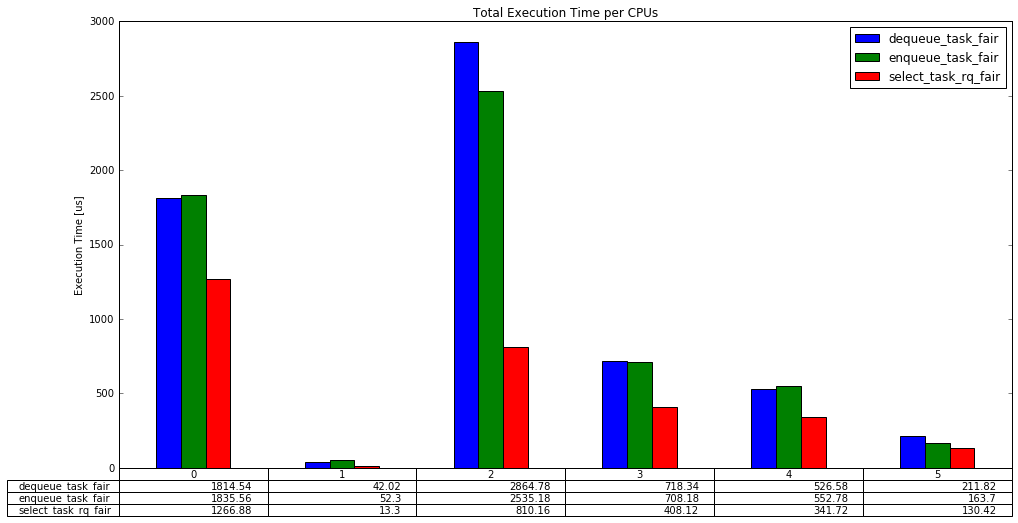

In [12]:
# Plot Average and Total execution time for the specified
# list of kernel functions
trace.analysis.functions.plotProfilingStats(
    functions = [
        'select_task_rq_fair',
        'enqueue_task_fair',
        'dequeue_task_fair'
    ],
    metrics = [
        'avg',
        'time',
    ]
)

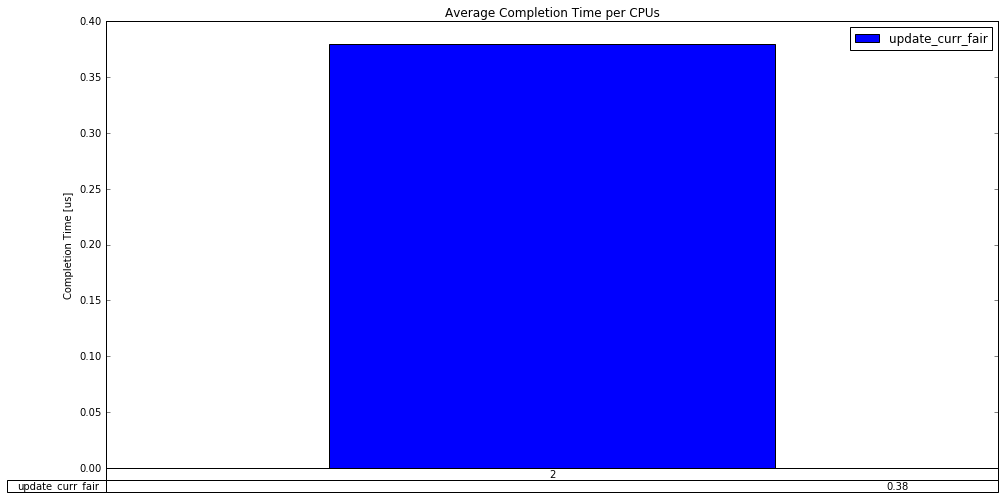

In [14]:
# Plot Average execution time for the single specified kernel function
trace.analysis.functions.plotProfilingStats(
    functions = 'update_curr_fair',
)